<a href="https://colab.research.google.com/github/jahnavinischal/ozone-forecasting-using-time-series/blob/main/ozone_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install --upgrade --force-reinstall numpy pandas scipy scikit-learn matplotlib statsmodels tensorflow keras


In [ ]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
# from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df=pd.read_csv('/content/antarctic-ozone-hole-area.csv')
df.head()

,Entity,Code,Year,Maximum ozone hole area (NASA),Mean ozone hole area
0,World,OWID_WRL,1979,1100000.0,100000
1,World,OWID_WRL,1980,3300000.0,1400000
2,World,OWID_WRL,1981,3100000.0,600000
3,World,OWID_WRL,1982,10800000.0,4800000
4,World,OWID_WRL,1983,12200000.0,7900000


# Pre-processing

In [ ]:
df.isnull().sum()

,0
Entity,0
Code,0
Year,0
Maximum ozone hole area (NASA),0
Mean ozone hole area,0


In [ ]:
(df==0).any()

,0
Entity,False
Code,False
Year,False
Maximum ozone hole area (NASA),False
Mean ozone hole area,False


In [ ]:
print(df['Entity'].unique())
print(df['Code'].unique())


['World']
['OWID_WRL']


In [ ]:
df.drop(['Code'],axis=1,inplace=True)
df.drop(['Entity'],axis=1,inplace=True)

In [ ]:
df.rename(columns={
    'Maximum ozone hole area (NASA)': 'Max_Ozone',
    'Mean ozone hole area': 'Mean_Ozone'
}, inplace=True)


In [ ]:
df.isnull().sum()

,0
Year,0
Max_Ozone,0
Mean_Ozone,0


In [ ]:
df['Max_Ozone'] = np.log1p(df['Max_Ozone'])
df['Mean_Ozone'] = np.log1p(df['Mean_Ozone'])

In [ ]:
df['Ozone_Gap'] = df['Max_Ozone'] - df['Mean_Ozone']

In [ ]:
# normalize/log transform
df['Log_Max_Ozone'] = np.log1p(df['Max_Ozone'])
df['Log_Mean_Ozone'] = np.log1p(df['Mean_Ozone'])

In [ ]:
df.head()

,Year,Max_Ozone,Mean_Ozone,Ozone_Gap,Log_Max_Ozone,Log_Mean_Ozone
0,1979,13.910822,11.512935,2.397886,2.702087,2.526763
1,1980,15.009433,14.151984,0.857450,2.773178,2.718131
2,1981,14.946913,13.304687,1.642226,2.769265,2.660587
3,1982,16.195057,15.384127,0.810930,2.844622,2.796313
4,1983,16.316947,15.882373,0.434573,2.851686,2.826270


In [ ]:
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

df.set_index('Year', inplace=True)
df = df.asfreq('YS')  # set yearly frequency

print("Summary Statistics:")
print(df.describe())

Summary Statistics:
       Max_Ozone  Mean_Ozone  Ozone_Gap  Log_Max_Ozone  Log_Mean_Ozone
count  41.000000   41.000000  41.000000      41.000000       41.000000
mean   16.753583   16.462073   0.291510       2.875846        2.857788
std     0.665835    1.099154   0.448473       0.039737        0.070435
min    13.910822   11.512935   0.053843       2.702087        2.526763
25%    16.791040   16.468753   0.096730       2.878695        2.860414
50%    16.993564   16.855260   0.135802       2.890014        2.882298
75%    17.065885   16.976757   0.242425       2.894025        2.889080
max    17.213369   17.096422   2.397886       2.902156        2.895714


In [ ]:
df.isnull().sum()

,0
Max_Ozone,1
Mean_Ozone,1
Ozone_Gap,1
Log_Max_Ozone,1
Log_Mean_Ozone,1


In [ ]:
df.interpolate(method='linear', inplace=True)
df.isnull().sum()

,0
Max_Ozone,0
Mean_Ozone,0
Ozone_Gap,0
Log_Max_Ozone,0
Log_Mean_Ozone,0


<Figure size 1000x800 with 0 Axes>

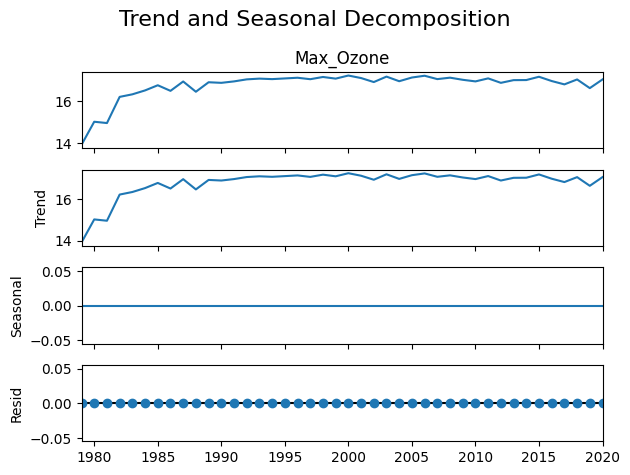

In [ ]:
# Seasonal Decomposition
decomposition = seasonal_decompose(df['Max_Ozone'], model='additive', period=1)

plt.figure(figsize=(10, 8))
decomposition.plot()
plt.suptitle("Trend and Seasonal Decomposition", fontsize=16)
plt.tight_layout()
plt.show()

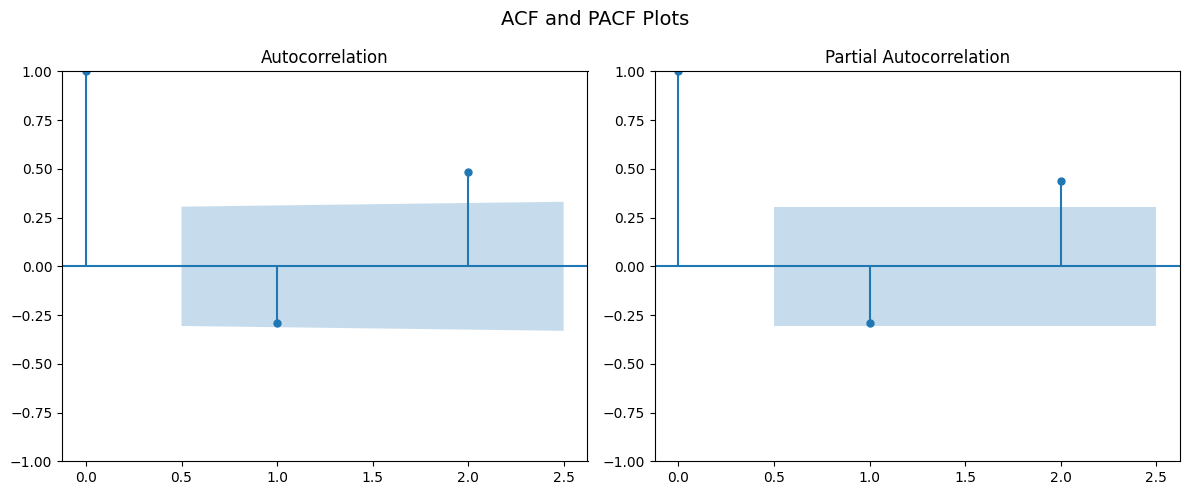

In [ ]:
# ACF and PACF Plots
diff_series = df['Max_Ozone'].diff().dropna()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(diff_series, ax=plt.gca(), lags=2)
plt.subplot(1, 2, 2)
plot_pacf(diff_series, ax=plt.gca(), lags=2)
plt.suptitle("ACF and PACF Plots", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Stationarity test

# ADF Test
print("ADF Test:")
adf_result = adfuller(df['Max_Ozone'].dropna())
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("=> Stationary" if adf_result[1] < 0.05 else "=> Non-stationary")

# KPSS Test
print("\nKPSS Test:")
kpss_result = kpss(df['Max_Ozone'].dropna(), regression='c', nlags="auto")
print(f"KPSS Statistic: {kpss_result[0]:.4f}")
print(f"p-value: {kpss_result[1]:.4f}")
print("=> Non-stationary" if kpss_result[1] < 0.05 else "=> Stationary")


ADF Test:
ADF Statistic: -3.7065
p-value: 0.0040
=> Stationary

KPSS Test:
KPSS Statistic: 0.5091
p-value: 0.0396
=> Non-stationary


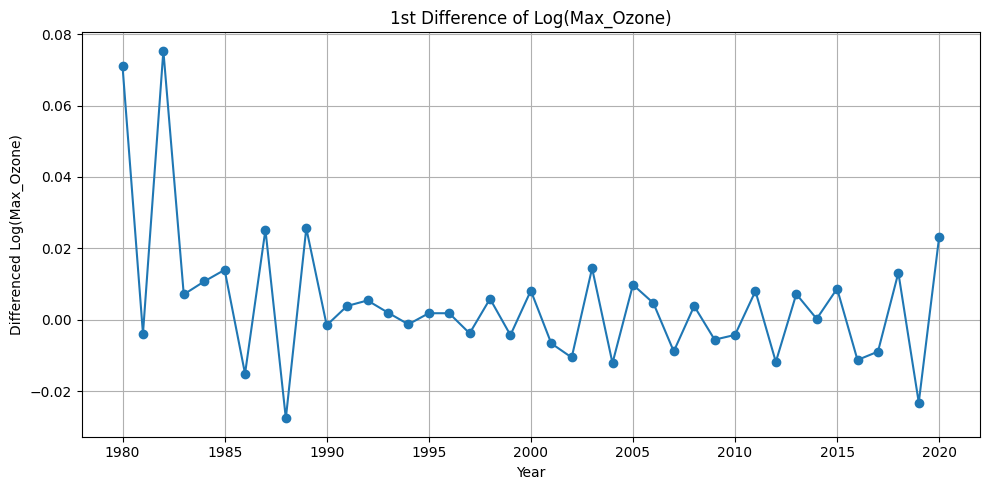

In [ ]:
# First-order differencing to achieve stationarity
df['Log_Max_Ozone_Diff'] = df['Log_Max_Ozone'].diff()

# Drop NA introduced by differencing
df_diff = df.dropna()

# Plot the differenced series
plt.figure(figsize=(10, 5))
plt.plot(df_diff['Log_Max_Ozone_Diff'], marker='o')
plt.title("1st Difference of Log(Max_Ozone)")
plt.xlabel("Year")
plt.ylabel("Differenced Log(Max_Ozone)")
plt.grid()
plt.tight_layout()
plt.show()

# Applying ARIMA and SARIMA model on log-transformed data

                               SARIMAX Results                                
Dep. Variable:          Log_Max_Ozone   No. Observations:                   42
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 105.973
Date:                Wed, 30 Apr 2025   AIC                           -205.947
Time:                        06:06:13   BIC                           -200.806
Sample:                    01-01-1979   HQIC                          -204.075
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7864      0.149     -5.285      0.000      -1.078      -0.495
ma.L1          0.4104      0.239      1.717      0.086      -0.058       0.879
sigma2         0.0003   5.95e-05      5.560      0.0

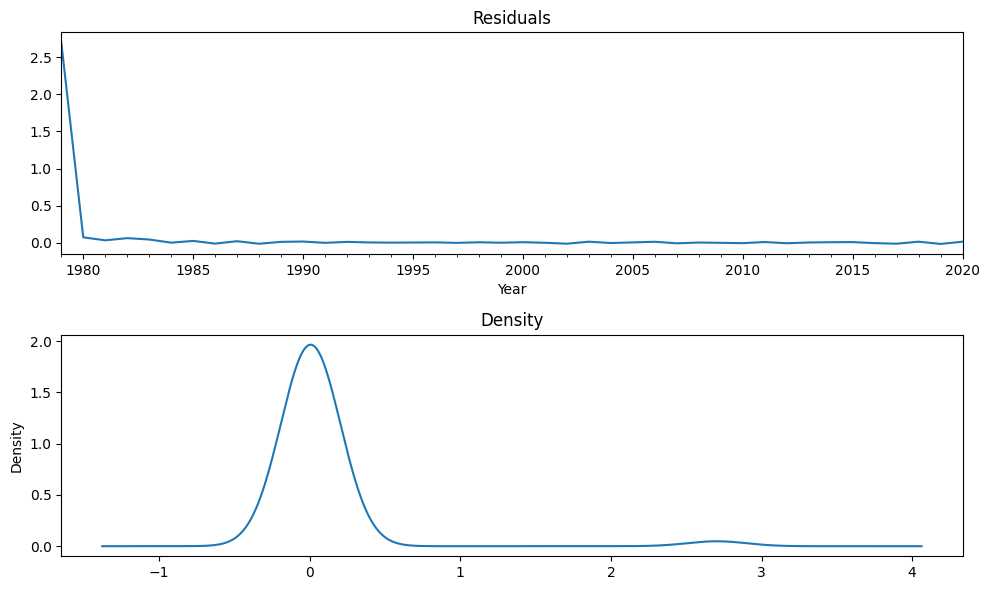

In [ ]:
# Based on ACF/PACF, taking ARIMA(1,1,1)
from statsmodels.tsa.arima.model import ARIMA

arima_model_trans = ARIMA(df['Log_Max_Ozone'], order=(1, 1, 1))  # (p,d,q)
arima_result = arima_model_trans.fit()
print(arima_result.summary())

# Plot residuals
residuals = arima_result.resid
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.tight_layout()
plt.show()



                                     SARIMAX Results                                      
Dep. Variable:                      Log_Max_Ozone   No. Observations:                   42
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -550.290
Date:                            Wed, 30 Apr 2025   AIC                           1110.580
Time:                                    05:54:47   BIC                           1117.059
Sample:                                01-01-1979   HQIC                          1112.506
                                     - 01-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0240         -0       -inf      0.000       0.024       0.024
ma.L1         -0.5262         -0   

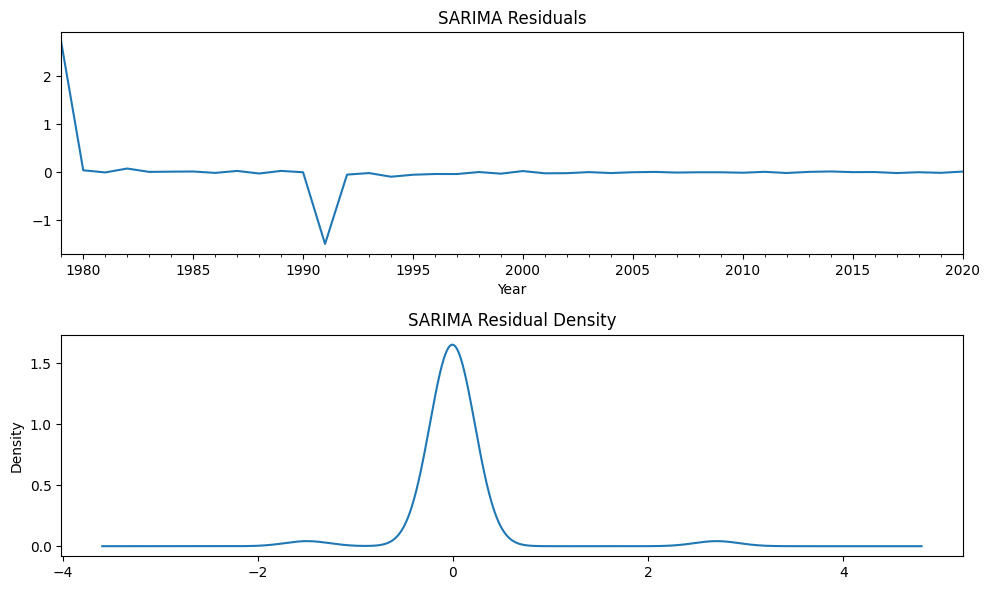

In [ ]:
sarima_model_trans = SARIMAX(df['Log_Max_Ozone'],
                       order=(1, 1, 1),
                       seasonal_order=(1, 0, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_result = sarima_model_trans.fit()
print(sarima_result.summary())

# Plot residuals
sarima_resid = sarima_result.resid
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
sarima_resid.plot(title="SARIMA Residuals", ax=ax[0])
sarima_resid.plot(kind='kde', title='SARIMA Residual Density', ax=ax[1])
plt.tight_layout()
plt.show()


In [ ]:
# ARIMA or SARIMA based on stationarity & seasonality
# Since yearly data and only 5 points, seasonality isn't meaningful here; use ARIMA
model = SARIMAX(df['Max_Ozone'], order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
result1 = model.fit()

print("\nModel Summary:")
print(result1.summary())


Model Summary:
                               SARIMAX Results                                
Dep. Variable:              Max_Ozone   No. Observations:                   42
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  -9.180
Date:                Wed, 30 Apr 2025   AIC                             24.360
Time:                        06:06:24   BIC                             29.501
Sample:                    01-01-1979   HQIC                            26.232
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7712      0.167     -4.604      0.000      -1.099      -0.443
ma.L1          0.3889      0.262      1.486      0.137      -0.124       0.902
sigma2         0.0908      0.018    

In [ ]:
print("ARIMA AIC:", arima_result.aic)
print("SARIMA AIC:", sarima_result.aic)


ARIMA AIC: -205.9469877229394
SARIMA AIC: 1110.5796237709085


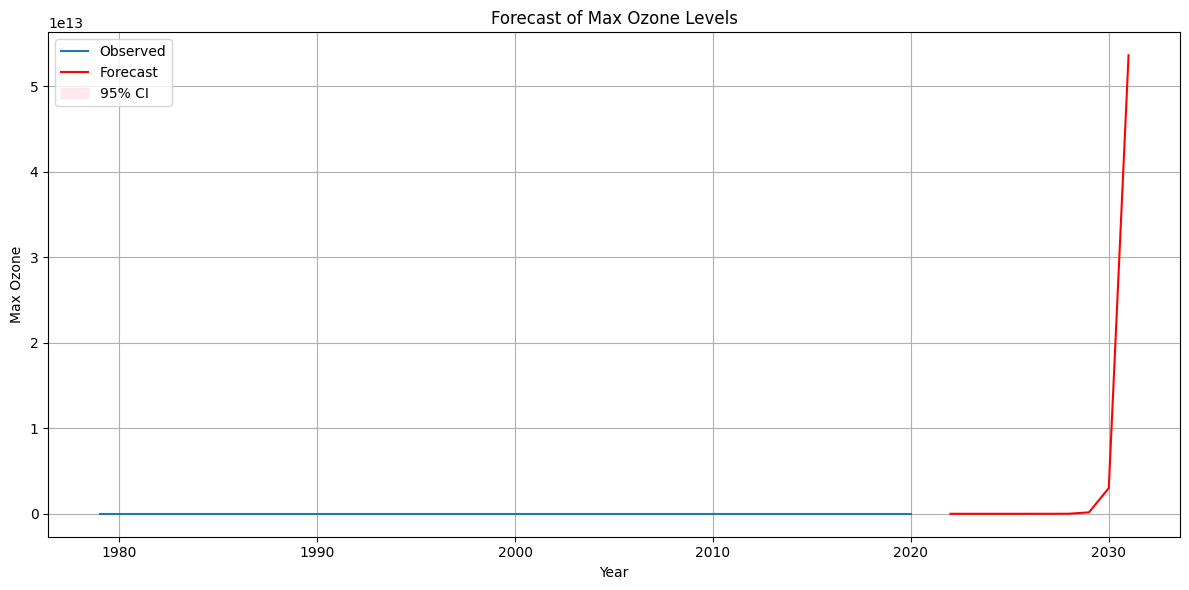

In [ ]:
forecast_steps = 10

# Forecast
forecast_result = arima_result.get_forecast(steps=forecast_steps)
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

# Invert first differencing
last_log_value = np.log(df['Max_Ozone']).iloc[-1]
forecast_cumsum = forecast_mean.cumsum()
forecast_log = last_log_value + forecast_cumsum

# Invert log transformation
forecast_final = np.exp(forecast_log)

# Forecast index
forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(years=1), periods=forecast_steps, freq='Y')
forecast_final.index = forecast_index

plt.figure(figsize=(12, 6))
plt.plot(df['Max_Ozone'], label='Observed')
plt.plot(forecast_final, label='Forecast', color='red')
plt.fill_between(forecast_final.index,
                 np.exp(last_log_value + forecast_cumsum + forecast_ci.iloc[:, 0]),
                 np.exp(last_log_value + forecast_cumsum + forecast_ci.iloc[:, 1]),
                 color='pink', alpha=0.3, label='95% CI')
plt.title('Forecast of Max Ozone Levels')
plt.xlabel('Year')
plt.ylabel('Max Ozone')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


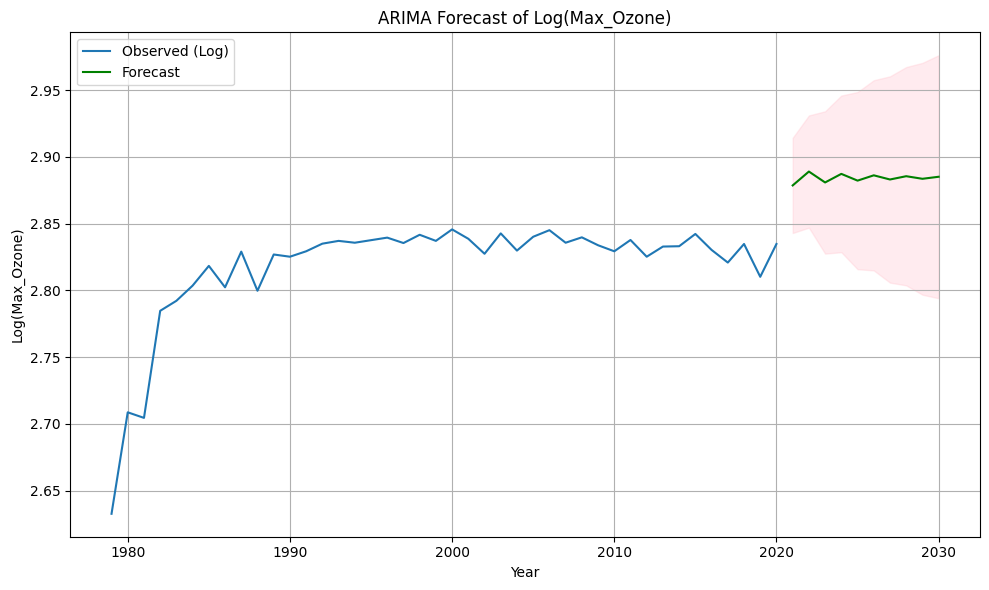

In [ ]:
# Forecasting future steps (on log-transformed series)
forecast_steps = 10
forecast_result = arima_result.get_forecast(steps=forecast_steps)
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Plot log-scale forecast
plt.figure(figsize=(10, 6))
plt.plot(np.log(df['Max_Ozone']), label='Observed (Log)')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='green')
plt.fill_between(forecast_mean.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA Forecast of Log(Max_Ozone)')
plt.xlabel('Year')
plt.ylabel('Log(Max_Ozone)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Check ARIMA residuals using Ljung-Box test (for white noise)

In [ ]:
log_series = df['Log_Max_Ozone'].dropna()

# Fit the best ARIMA model again (replace with your selected order if needed)
model_arima = sm.tsa.ARIMA(log_series, order=(1, 1, 1))  # replace p, d, q with your ARIMA order
results_arima1 = model_arima.fit()

# 1. Check residuals: Ljung-Box test
ljung_result = acorr_ljungbox(results_arima1.resid, lags=[10], return_df=True)
print("\nLjung-Box test for ARIMA residuals:")
print(ljung_result)


Ljung-Box test for ARIMA residuals:
     lb_stat  lb_pvalue
10  0.073753        1.0


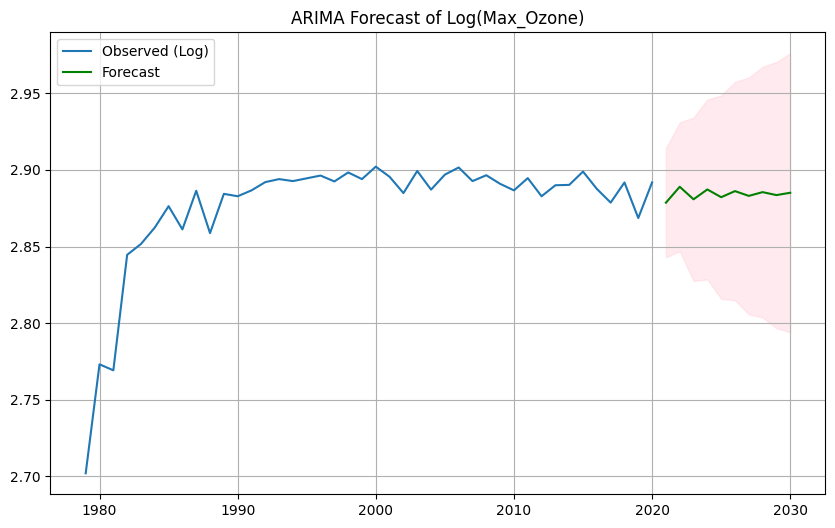

In [ ]:
# Forecast future values
forecast_steps = 10
forecast = results_arima1.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot forecast
plt.figure(figsize=(10, 6))
plt.plot(log_series, label='Observed (Log)')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='green')
plt.fill_between(forecast_mean.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA Forecast of Log(Max_Ozone)')
plt.legend()
plt.grid(True)
plt.show()

# applying ARIMA on non-log transformed data

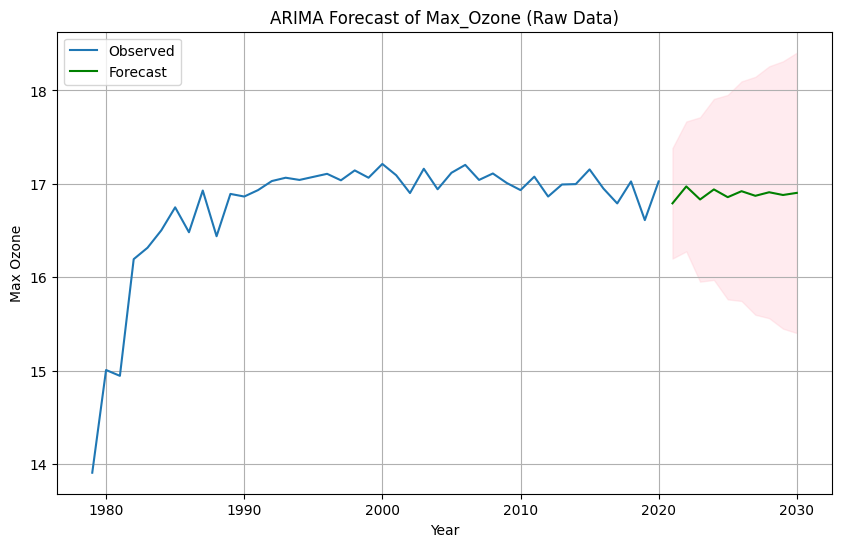

In [ ]:
# Fit ARIMA model without log-transform
model = ARIMA(df['Max_Ozone'], order=(1, 1, 1))
fitted_model_non_trans = model.fit()

# Forecast next 10 years
forecast_steps = 10
forecast_result = fitted_model_non_trans.get_forecast(steps=forecast_steps)
forecast_values = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

# Plot original data + forecast
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Max_Ozone'], label='Observed')
plt.plot(forecast_values.index, forecast_values, color='green', label='Forecast')

plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)

plt.title('ARIMA Forecast of Max_Ozone (Raw Data)')
plt.xlabel('Year')
plt.ylabel('Max Ozone')
plt.legend()
plt.grid(True)
plt.show()


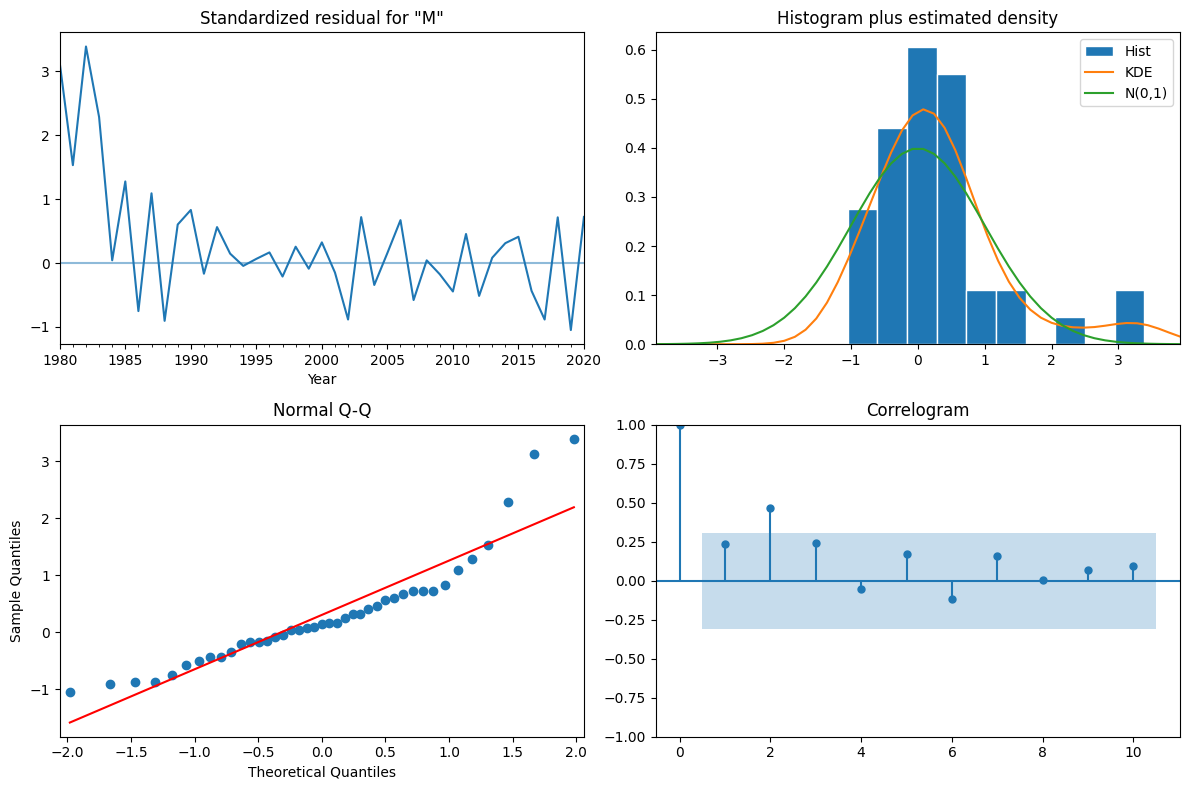

Split Evaluation:
Mean Squared Error: 0.03485334001393953
Mean Absolute Error: 0.13366145273701788


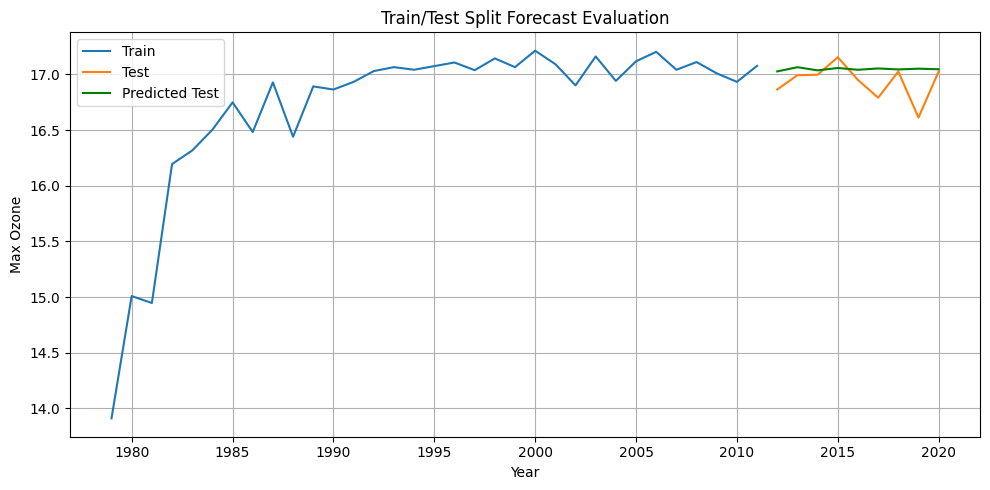

In [ ]:
# Diagnostics
fitted_model_non_trans.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

# Accuracy Check with Train/Test Split
train_size = int(len(df) * 0.8)
train, test = df['Max_Ozone'][:train_size], df['Max_Ozone'][train_size:]

model_split = ARIMA(train, order=(1, 1, 1))
fitted_split = model_split.fit()
forecast_split = fitted_split.forecast(steps=len(test))

# Evaluate
mse = mean_squared_error(test, forecast_split)
mae = mean_absolute_error(test, forecast_split)
print("Split Evaluation:")
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast_split, label='Predicted Test', color='green')
plt.title('Train/Test Split Forecast Evaluation')
plt.xlabel('Year')
plt.ylabel('Max Ozone')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# applying auto-arima

In [ ]:
# !pip uninstall numpy scipy pandas statsmodels pmdarima -y
# !pip install numpy==1.24.4 scipy==1.10.1 pandas==1.5.3 statsmodels==0.13.5 pmdarima==2.0.3 --no-cache-dir


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=5.602, Time=0.45 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=50.325, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=16.190, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=25.271, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=48.438, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=8.612, Time=0.29 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=3.741, Time=0.28 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=10.739, Time=0.18 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=4.508, Time=0.21 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=5.377, Time=0.50 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=4.072, Time=0.26 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=7.139, Time=0.87 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=3.113, Time=0.10 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=10.463, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=4.798, Time=0.05 sec
 ARIMA

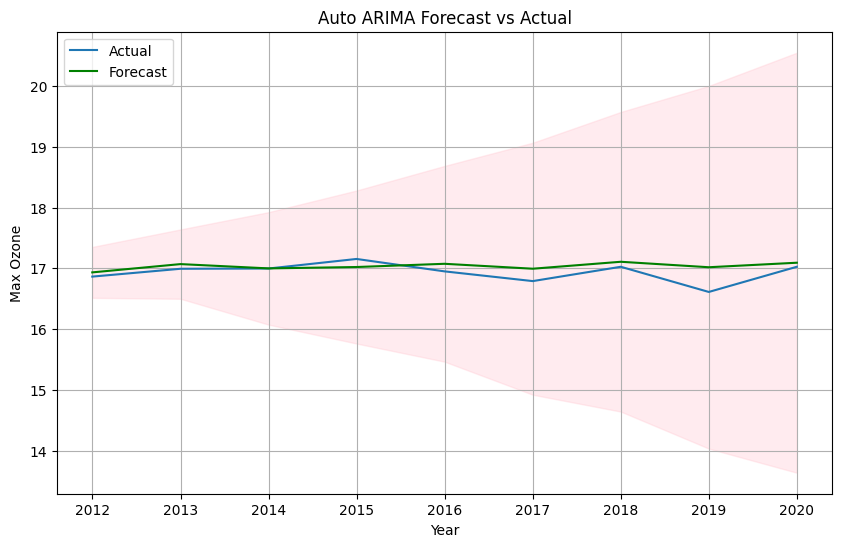

In [ ]:
from pmdarima import auto_arima


# Train-test split
train_size = int(len(df) * 0.8)
train, test = df['Max_Ozone'][:train_size], df['Max_Ozone'][train_size:]

# Auto ARIMA to find best (p,d,q)
auto_model = auto_arima(train, seasonal=False, stepwise=True, trace=True,
                        suppress_warnings=True, error_action="ignore")

print("Best ARIMA order found by AutoARIMA:", auto_model.order)

# Fit final ARIMA model with chosen order
final_model = ARIMA(train, order=auto_model.order)
fitted_model = final_model.fit()

# Forecast
forecast_result = fitted_model.get_forecast(steps=len(test))
predicted = forecast_result.predicted_mean
actual = test

# Metrics
mse = mean_squared_error(actual, predicted)
mae = mean_absolute_error(actual, predicted)
print("MSE:", mse)
print("MAE:", mae)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(actual.index, actual, label='Actual')
plt.plot(predicted.index, predicted, label='Forecast', color='green')
plt.fill_between(predicted.index,
                 forecast_result.conf_int().iloc[:, 0],
                 forecast_result.conf_int().iloc[:, 1],
                 color='pink', alpha=0.3)
plt.title('Auto ARIMA Forecast vs Actual')
plt.xlabel('Year')
plt.ylabel('Max Ozone')
plt.legend()
plt.grid(True)
plt.show()


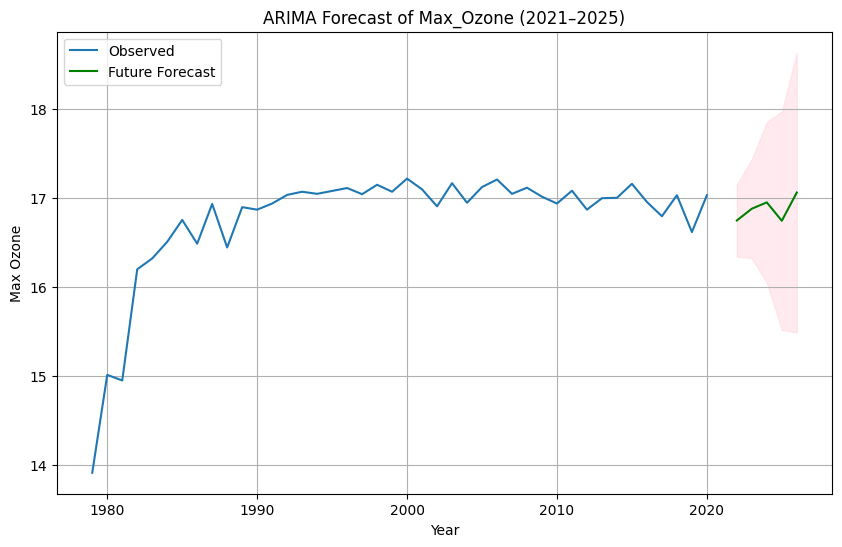

In [ ]:
# Fit ARIMA model to forecast future values
final_model = ARIMA(df['Max_Ozone'], order=auto_model.order)
fitted_model = final_model.fit()

# Forecast next 5 years
future_steps = 5
future_forecast = fitted_model.get_forecast(steps=future_steps)
future_values = future_forecast.predicted_mean
future_ci = future_forecast.conf_int()

# Create future date index
last_year = df.index[-1].year
future_index = pd.date_range(start=f'{last_year+1}', periods=future_steps, freq='Y')
future_values.index = future_index
future_ci.index = future_index

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Max_Ozone'], label='Observed')
plt.plot(future_values.index, future_values, color='green', label='Future Forecast')
plt.fill_between(future_ci.index,
                 future_ci.iloc[:, 0],
                 future_ci.iloc[:, 1], color='pink', alpha=0.3)

plt.title('ARIMA Forecast of Max_Ozone (2021–2025)')
plt.xlabel('Year')
plt.ylabel('Max Ozone')
plt.legend()
plt.grid(True)
plt.show()


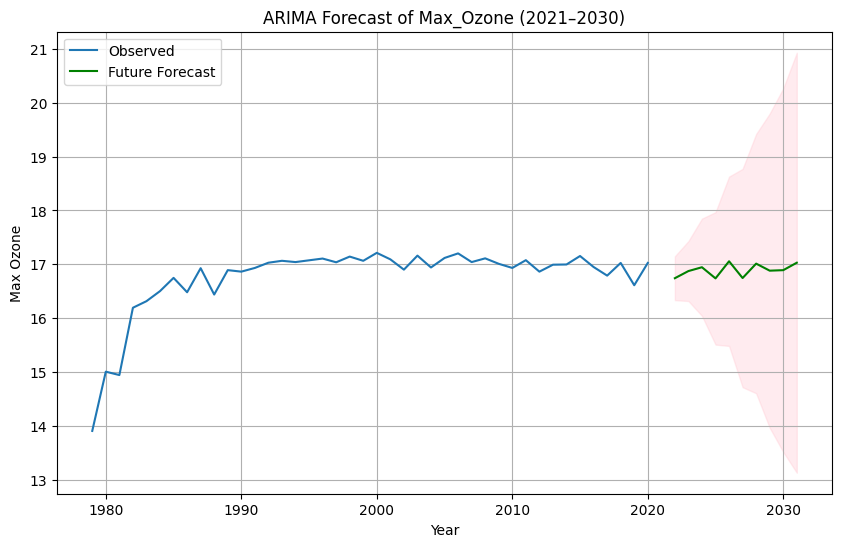

In [ ]:
# --- Fit model on full dataset ---
final_model = ARIMA(df['Max_Ozone'], order=auto_model.order)
fitted_model = final_model.fit()

# --- Forecast next 5 years ---
future_steps = 10
future_forecast = fitted_model.get_forecast(steps=future_steps)
future_values = future_forecast.predicted_mean
future_ci = future_forecast.conf_int()

# --- Create future date index ---
last_year = df.index[-1].year
future_index = pd.date_range(start=f'{last_year+1}', periods=future_steps, freq='Y')
future_values.index = future_index
future_ci.index = future_index

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Max_Ozone'], label='Observed')
plt.plot(future_values.index, future_values, color='green', label='Future Forecast')
plt.fill_between(future_ci.index,
                 future_ci.iloc[:, 0],
                 future_ci.iloc[:, 1], color='pink', alpha=0.3)

plt.title('ARIMA Forecast of Max_Ozone (2021–2030)')
plt.xlabel('Year')
plt.ylabel('Max Ozone')
plt.legend()
plt.grid(True)
plt.show()


# exponential smoothing

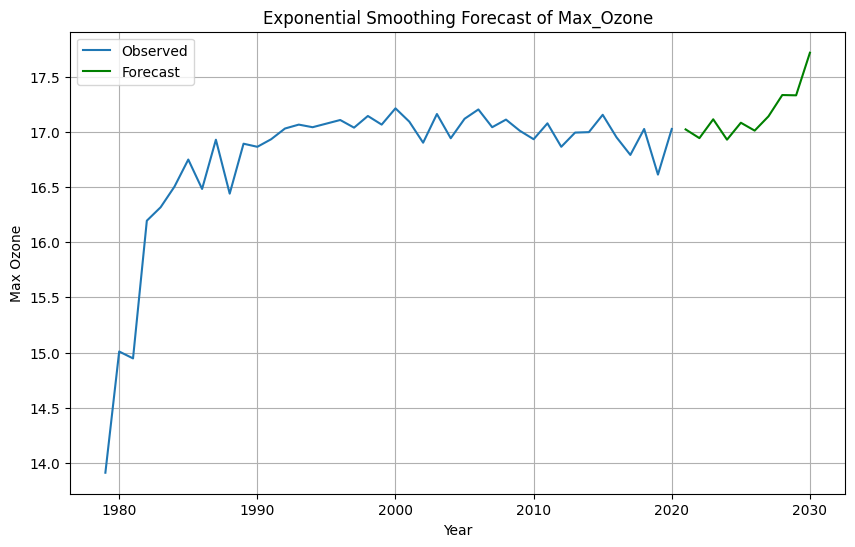

In [ ]:
# Apply Holt-Winters Exponential Smoothing
model = ExponentialSmoothing(df['Max_Ozone'], trend='add', seasonal='add', seasonal_periods=12)
ES_model = model.fit()

# Forecast the next 5 years (or steps)
forecast = ES_model.forecast(steps=10)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Max_Ozone'], label='Observed')
plt.plot(forecast.index, forecast, color='green', label='Forecast')
plt.title('Exponential Smoothing Forecast of Max_Ozone')
plt.xlabel('Year')
plt.ylabel('Max Ozone')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Split into train and test
train = df['Max_Ozone'][:-5]
test = df['Max_Ozone'][-5:]

# Fit model on train set
model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
ES_model = model.fit()

# Forecast same length as test
forecast = ES_model.forecast(steps=5)

# Evaluation
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)

print("Evaluation on Test Set:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")



Evaluation on Test Set:
Mean Absolute Error (MAE): 0.91
Mean Squared Error (MSE): 0.91


# knn

Forecasted value for next step: 16.94


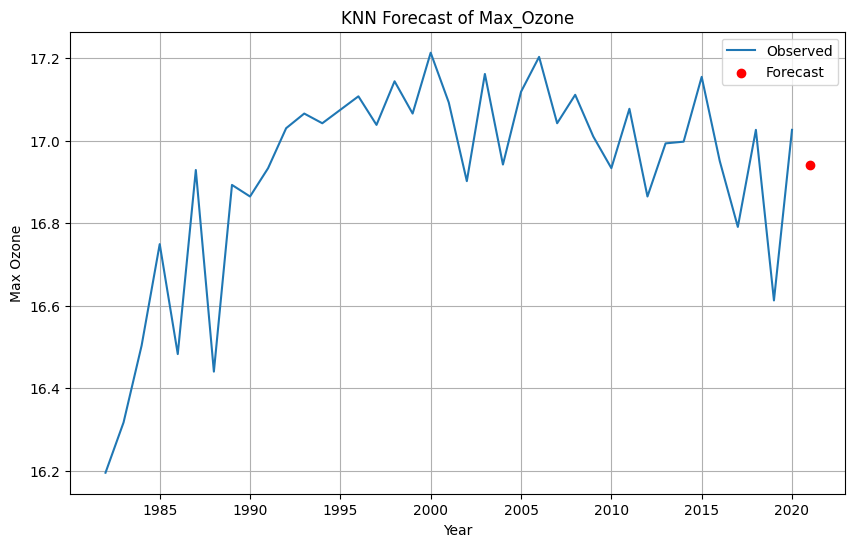

In [ ]:
# Prepare lagged features for KNN
df['Lag_1'] = df['Max_Ozone'].shift(1)

# Drop missing values (after shift)
df = df.dropna()

# Train-test split
X = df['Lag_1'].values.reshape(-1, 1)
y = df['Max_Ozone'].values

# Train KNN model
model = KNeighborsRegressor(n_neighbors=3)
model.fit(X, y)

# Forecast next step
forecast = model.predict([[df['Max_Ozone'].iloc[-1]]])

# Print the forecasted value
print(f"Forecasted value for next step: {forecast[0]:.2f}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Max_Ozone'], label='Observed')
plt.scatter(df.index[-1] + pd.Timedelta(days=365), forecast, color='red', label='Forecast')
plt.title('KNN Forecast of Max_Ozone')
plt.xlabel('Year')
plt.ylabel('Max Ozone')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Lag feature
df['Lag_1'] = df['Max_Ozone'].shift(1)
df = df.dropna()

# Features and target
X = df['Lag_1'].values.reshape(-1, 1)
y = df['Max_Ozone'].values

# Train-test split (e.g., last 5 for test)
split_index = -5
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Train model
model = KNeighborsRegressor(n_neighbors=3)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("KNN Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")




KNN Evaluation:
Mean Absolute Error (MAE): 0.28
Mean Squared Error (MSE): 0.09
